In [20]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import matplotlib.pyplot as plt
import os
import pickle
import random 
import operator
import math
import numpy as np
import os
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
from scipy.fft import fft, ifft
from collections import Counter
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score
pd.options.display.max_columns = 999

user = "\Sofus"

os.chdir(r"C:\Users"+user+"\Dropbox\PhD\ML\BigProjectGithub\music\wav")

def chunk_using_generators(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def zerocrossing(x):
    n0 = 0
    n1 = 9100
    zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
    #print(sum(zero_crossings))
    return sum(zero_crossings)

def spectral_rolloff(x):
    spectral_rolloff1 = librosa.feature.spectral_rolloff(x+0.01, sr=sr)
    return np.mean(spectral_rolloff1)

def chromagram(x):
    hop_length = 512
    chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
    return(np.mean(chromagram),np.std(chromagram))


def fourier(x):
    yf = fft(x)
    return np.mean(np.abs(yf)),np.std(np.abs(yf))

def chroma_cens(x):
    #tempo = librosa.beat.tempo(x_cut, sr=22050, onset_envelope=None, hop_length=512, 
                   #start_bpm=100, std_bpm=1.0, ac_size=8.0, max_tempo=180.0)
    tempo = librosa.feature.chroma_cens(x)
    return(np.mean(tempo[0]))

def read_data(features,timbre_features,filename,file_timbre):
    pdread = pd.read_csv(filename)
    dataframe = pd.DataFrame({})
    pdread_timbre = pd.read_csv(file_timbre)
    
    for l in range(len(features)):
        data_feature = np.array(pdread[pdread.index==l])
        data_feature[0][1:-1]
        dataframe[features[l]]=data_feature[0][1:-1]

    for l in range(len(timbre_features)):
        data_feature = np.array(pdread_timbre[pdread_timbre.index==l])
        dataframe[timbre_features[l]]=data_feature[0][1:-1]

    return(dataframe)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
#directory = r'C:\musicproject'
os.chdir(r"C:\Users"+user+"\Dropbox\PhD\ML\BigProjectGithub\music\wav")
      
#= open('zy.dat' ,'wb')
os.listdir()
i=0

rock_sig, disco_sig = [],[]
blues_sig = []
sig_array = []
classes = []
chroma_cens_lib = []
fourier_mean = []
fourier_std = []
df = np.array([])

zerocrossing_data =[]
spectral_rolloff_data = []
chromagram_mean_data = []
chromagram_std_data = []

features = ['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std','fourier_mean','chroma_cens', 'class']
timbre_features = ['hardness','depth','brightness','roughness','warmth','sharpness','boominess','reverb']

folders = ['pop','jazz','blues','classical','hiphop','metal','rock','reggae','disco','country']
i=-1

write_data = False

if write_data == True:
    for folder in folders:
        i=i+1

        print(folder)
        j=0
        for file in os.listdir(folder):  
            j+=1
            path = "C:\\Users"+user+"\\Dropbox\\PhD\\ML\\BigProjectGithub\\music\\wav\\"+folder+"\\"+file
            x , sr = librosa.load(path)
            #print(x.shape, sr)

            for k in range(11):
                x_cut = x[(0+k)*60000:(1+k)*60000]
                #x_cut= x
                classes.append(i)
                zerocrossing_data.append(zerocrossing(x_cut))
                spectral_rolloff_data.append(spectral_rolloff(x_cut))

                fmean,fstd = fourier(x_cut)

                chroma_cens_lib.append(chroma_cens(x_cut))

                fourier_mean.append(fmean)
                fourier_std.append(fstd)

                chrmean, chrstd = chromagram(x_cut)
                chromagram_mean_data.append(chrmean)
                chromagram_std_data.append(chrstd)
                #print(path)

            #if j==2:
            #    break  
    features_write = np.array([zerocrossing_data, spectral_rolloff_data, chroma_cens_lib, fourier_mean, fourier_std, chromagram_mean_data, chromagram_std_data, classes])
    os.chdir(r'C:\Users\Sofus\Dropbox\PhD\ML\BigProjectGithub\music')
    DF = pd.DataFrame(features_write)
    DF.to_csv("other_features.csv")

if write_data == False:
    os.chdir(r"C:\Users"+user+"\Dropbox\PhD\ML\BigProjectGithub\music")
    dataframe = read_data(features,timbre_features,"other_features.csv",'timbre_secure.csv')
    
    
    
#from numpy import random
#dataframe['randomtest']= random.randint(5, size=(len(dataframe)))

dataframe_cut = pd.DataFrame({})
chosen_genres = [0,1,2,3,4,5,6,7,8,9]
#hosen_genres = [3,5]

for i in chosen_genres:
    dataframe_cut = dataframe_cut.append(dataframe[dataframe['class']==i])
    

0.5975546243738463
[ 0  0  0  0  0  7  0  0 -1 -1  7 -3  4  8 -4  1  1  0 -3 -1  0  0  0 -2
  0  0  0 -4  0  4 -2  0 -5  0  0  0  4 -7 -5  0  0  0 -2  0  0  0  0  0
  0  0  1  0  0  0  0  0  8  0  0  0 -1  0 -1  1 -1  4  0  2 -1 -1  4  0
  0  3  0  0  0  1  0  0 -4  0  0  0 -1  3 -4  0  8  0  0  1  2 -4  0 -5
 -5  0  2  0  0  0 -2  0  4  0  0  0  7  0 -7  1  0  0  1  0  0  0  2  0
 -4  0 -1  0 -6  0  0 -1  0  0 -7  0 -1  0  0  5 -7  0 -1 -3  0  0  0  2
  0 -1 -7  0  0  0 -3  0  0 -3 -1  0 -6  0  0  0  0  0  0  0  0  0  0 -6
  0  0  0  0  2  0  0  0  0  0  0  5 -1  0  0 -1  0 -1  0  2  0  4 -3  0
  2  0  2  0  4  0 -4  0]


<ipython-input-44-81d916f9dcde>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(features)


[Text(0, 0.0, 'zerocrossing'),
 Text(0, 0.2, 'spectralrolloff'),
 Text(0, 0.4, 'chromagramstd'),
 Text(0, 0.6000000000000001, 'chromagrammean'),
 Text(0, 0.8, 'fourier_std'),
 Text(0, 1.0, 'fourier_mean')]

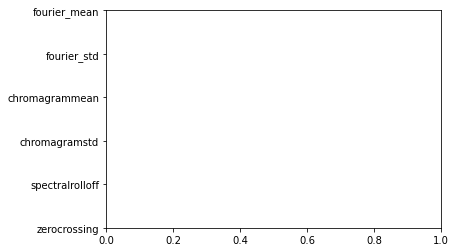

In [44]:
dataframe_cut['class_num'] = pd.factorize(dataframe_cut['class'])[0]

df_1=[]
train_features = ['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std',
                  'fourier_mean','chroma_cens','hardness','depth','brightness','roughness','warmth',
                  'sharpness','boominess']

df_1=dataframe_cut[train_features]

Y_1=dataframe_cut['class_num']

#Scaling using the Standard Scaler
sc_1=StandardScaler()
sc_1.fit(df_1)
X_1=pd.DataFrame(sc_1.fit_transform(df_1))



params={}
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=10
params['num_class']=10
params['num_leaves']=10
params['force_col_wise']=True
params['verbose'] = -1
params['learning_rate']=0.01
epochs = 500
#len(os.listdir()) #no.of unique values in the target class not inclusive of the end value
#training the model
score_array=[]

evals_result={}
test = False

if test==True:
    for param in range(50):
        #params['max_depth']=param+1
        X_train,X_test,y_train,y_test=train_test_split(X_1,Y_1,test_size=0.2,random_state=param+40)
        d_train=lgb.Dataset(X_train, label=y_train)

        clf=lgb.train(params,d_train,500)

        y_pred_1=clf.predict(X_test)

        y_pred_m = [np.argmax(line) for line in y_pred_1]

        score = precision_score(y_pred_m,y_test,average=None).mean()
        score_array.append(score)
        plt.plot(score_array)
else:
    X_train,X_test,y_train,y_test=train_test_split(X_1,Y_1,test_size=0.2,random_state=50)
    d_train=lgb.Dataset(X_train, label=y_train)
    
    clf=lgb.train(params,d_train ,epochs)

    y_pred_1=clf.predict(X_test)

    y_pred_m = [np.argmax(line) for line in y_pred_1]

    score = precision_score(y_pred_m,y_test,average=None).mean()

print(score)
print(np.array(y_test)-np.array(y_pred_m))
len(y_test)

#explainer = shap.TreeExplainer(clf)
#shap_values = explainer.shap_values(X_1)

fig, ax = plt.subplots()

ax.set_yticklabels(features)



In [18]:
np.mean(score_array)
np.std(score_array)

0.029566559239604294

In [21]:
########Test different genres accuracy

y_pred_m = np.array(y_pred_m)
y_test = np.array(y_test)

for jj in range(len(chosen_genres)):
    sum=0
    correct=0
    for kk in range(len(y_pred_m)):
        if y_test[kk] == jj:
            sum=sum+1
            if y_pred_m[kk] == jj:
                correct = correct +1
                
    print(folders[chosen_genres[jj]],correct/sum)

    

pop 0.6086956521739131
jazz 0.7272727272727273
blues 0.5555555555555556
classical 0.9523809523809523
hiphop 0.5833333333333334
metal 0.6666666666666666
rock 0.4
reggae 0.4583333333333333
disco 0.42857142857142855
country 0.5789473684210527


In [43]:
#dataframe.head()
#dataframe[dataframe['class']==0]


,zerocrossing,spectralrolloff,chromagramstd,chromagrammean,fourier_std,fourier_mean,chroma_cens,class,hardness,depth,brightness,roughness,warmth,sharpness,boominess,reverb
0,-0.851135,2.116395,0.343941,0.461131,1.046465,0.129964,0.592023,-1.566273,0.742421,1.794114,0.257451,-0.464511,0.291734,1.096321,0.360464,0.410391
1,-0.425409,2.199051,0.592302,1.802687,2.222829,0.422737,1.426974,-1.566273,1.038576,1.238953,0.938796,0.413594,-0.175984,1.371461,0.489101,-2.436699
2,-0.009630,1.790823,0.585668,0.804939,1.406788,0.474489,0.916390,-1.566273,0.551248,1.148642,0.261094,0.363020,0.133357,0.804913,0.964934,0.410391
3,-0.136950,-0.540270,0.436004,-0.175943,-0.022329,0.355342,-0.675808,-1.566273,0.139001,0.773216,-0.123419,-0.286385,0.453072,-0.412852,0.267085,0.410391
4,-0.439335,0.900626,0.009600,1.461478,0.995952,0.068456,-0.324025,-1.566273,0.817424,-0.030234,0.385656,0.723096,-0.385425,0.502699,-0.390476,0.410391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,-0.160823,-0.883478,1.185532,0.575764,1.177534,-0.145919,-0.274699,1.569412,-0.439291,0.204097,-0.833794,0.136202,1.156140,-0.996592,0.415088,0.410391
995,-0.799411,-0.816241,0.246080,0.358234,0.785520,-0.606735,0.629022,1.569412,-0.373958,-0.043568,-0.523551,-0.268473,0.681190,-0.832723,0.207273,0.410391
996,0.386255,-0.634183,0.094479,1.062684,1.272786,-0.647268,-0.032748,1.569412,0.539822,-0.616394,0.036962,0.559374,-0.102670,-0.416760,-0.554110,0.410391
997,-0.166791,-0.851154,0.445769,0.082483,0.376402,-0.374495,0.412507,1.569412,-0.194659,0.648630,-0.167320,0.029834,0.556089,-0.701621,0.157726,0.410391


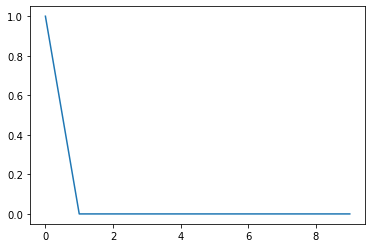

In [6]:
x = (0,1,2,3,4,5,6,7,8,9)
y = y_pred_1[0][:]
plt.plot(x,y)

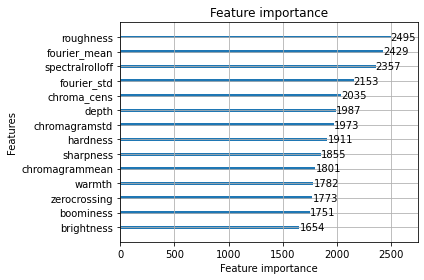

In [40]:
#######################Feature importance##############################################

axes = lgb.plot_importance(clf)

labels = [item.get_text() for item in axes.get_yticklabels()]

feature_imp_labels = []

for h in range(len(labels)):
    index = int(labels[h])
    feature_imp_labels.append(train_features[index])

axes.set_yticklabels(feature_imp_labels);
plt.tight_layout()
plt.savefig('featureimp.pdf')

In [42]:

df_1=dataframe_cut[train_features]

Y_1=dataframe_cut['class_num']

#Scaling using the Standard Scaler
sc_1=StandardScaler()
sc_1.fit(df_1)
X_1=pd.DataFrame(sc_1.fit_transform(df_1))


params={}
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=10
params['num_class']=10
params['num_leaves']=10
params['force_col_wise']=True
params['verbose'] = -1
params['learning_rate']=0.1
epochs = 500
#len(os.listdir()) #no.of unique values in the target class not inclusive of the end value
#training the model

evals_result={}
test = False

#params['max_depth']=param+1
d_train=lgb.Dataset(X_1, label=Y_1)
clf_cv=lgb.cv(params,d_train,eval_train_metric=True)

np.mean(clf_cv['train multi_logloss-mean'])

0.3009328758312573

0.10729553960019986

In [41]:
#kNeighbour cross validation
#scaling data

for col in dataframe.columns:
    if col == 'class':
        pass
    else:
        dat = dataframe[col]
        dat = dat - np.mean(dat)
        dat = dat/np.std(dat)
        dataframe[col] = dat

        
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=5)

# cross_validate
cv_scores = cross_val_score(knn, X_train, y_train, cv=50)

cv_scores_mean = np.mean(cv_scores)
print(cv_scores , "\n\n""mean =" ,"{:.2f}".format(cv_scores_mean))


np.std(cv_scores)

[0.4375     0.875      0.5        0.4375     0.5        0.5
 0.6875     0.3125     0.5        0.6875     0.6875     0.625
 0.625      0.3125     0.4375     0.5        0.625      0.6875
 0.5625     0.25       0.5        0.75       0.75       0.5
 0.5625     0.5625     0.625      0.5625     0.5        0.625
 0.5625     0.625      0.5        0.5        0.5        0.5625
 0.4375     0.5625     0.5625     0.625      0.375      0.5
 0.5625     0.5        0.5        0.5        0.625      0.4375
 0.6875     0.73333333] 

mean = 0.55


0.11784314551319668

Length of list 30
Max of list 0.5670833333333334


Text(0, 0.5, 'Cross-validated accuracy')

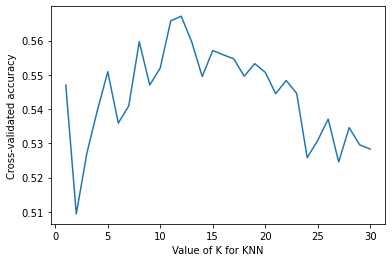

In [43]:

########################Find best n_neighbors##########################################

k_range = range(1, 31)
# empty list to store scores
k_scores = []


for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    cv_scores = cross_val_score(knn, X_train, y_train, cv=50)
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(cv_scores.mean())

print('Length of list', len(k_scores))
print('Max of list', max(k_scores))

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')
    

fourier_std
fourier_mean
chroma_cens
roughness
classical metal disco


<Figure size 432x288 with 0 Axes>

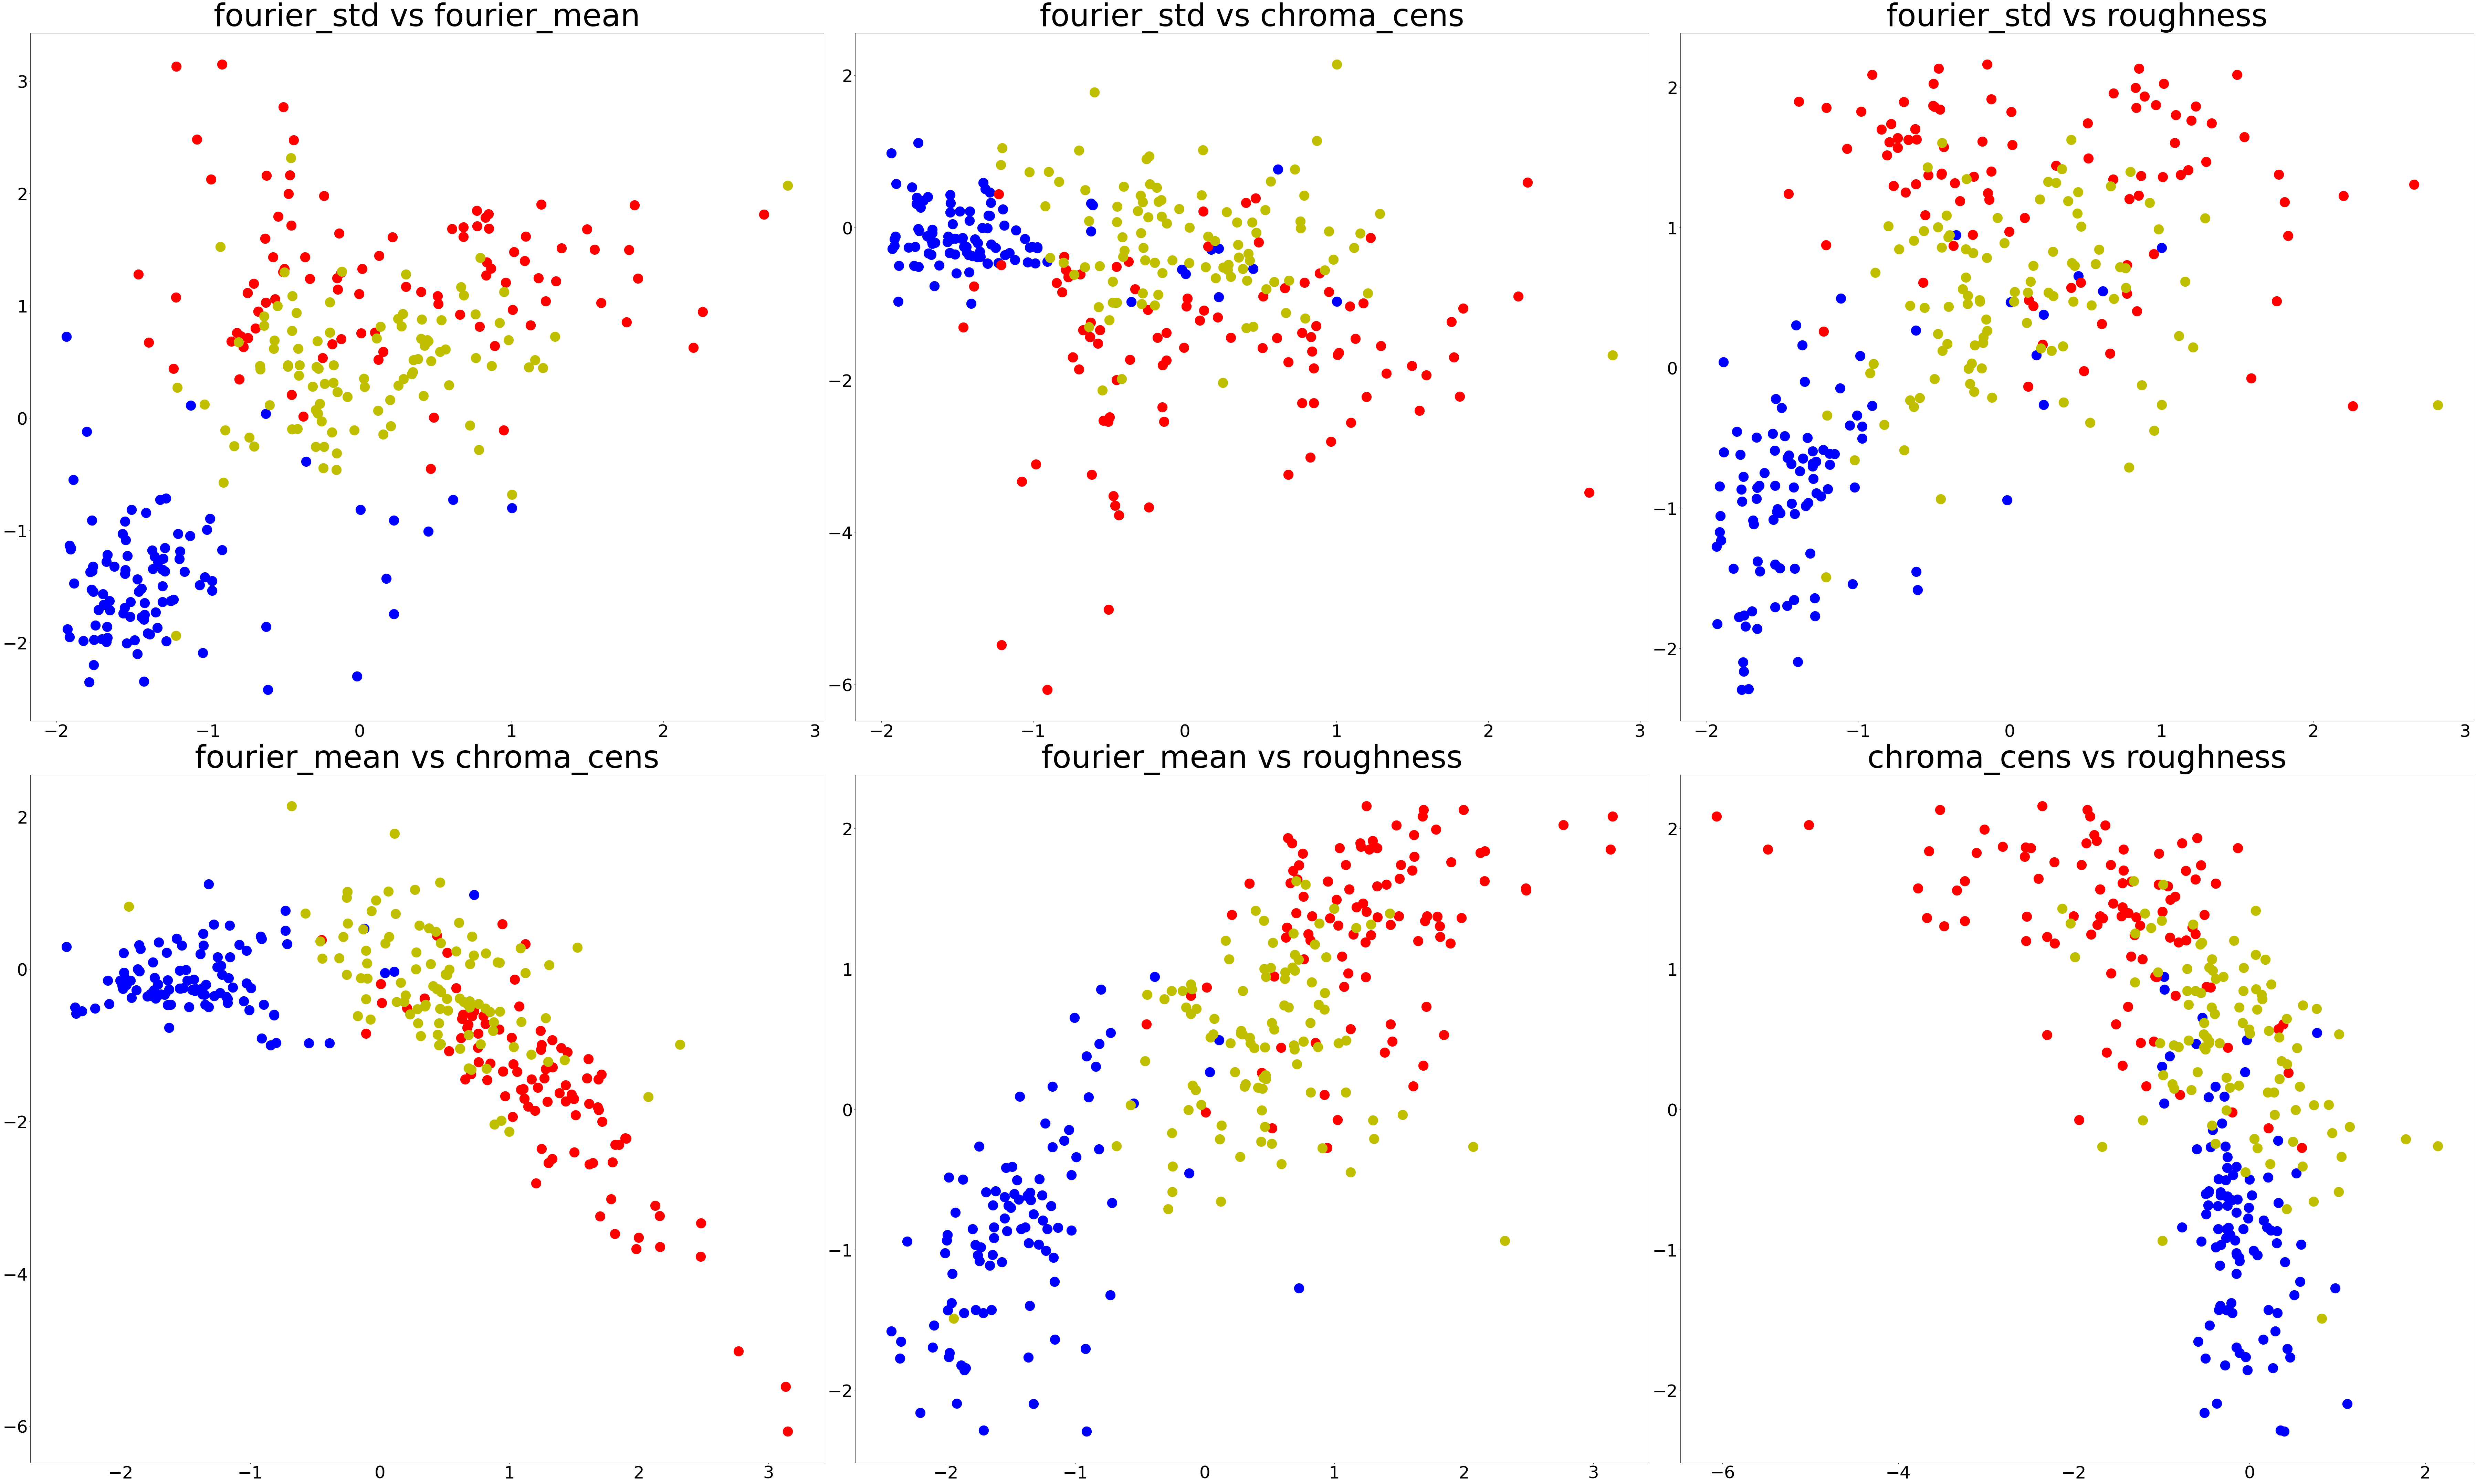

In [83]:
data_blues = dataframe[dataframe['class']==3]
#blue classical
data_rock = dataframe[dataframe['class']==5]
#red metal
data_disco = dataframe[dataframe['class']==8]
#yellow disco

#variable1 = 'fourier_std'
#variable2 = 'zerocrossing'

features_plot = ['fourier_std','fourier_mean','chroma_cens','roughness']


i=0
plot_index = 0
second_index =-1
f = plt.figure()    
f, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(100, 60))

for variable1 in features_plot:
    i=i+1
    print(variable1)
    for j in range(i,len(features_plot)):
        variable2 = features_plot[j]
        
        mod_index = plot_index % 3
        if mod_index ==0:
            second_index = second_index +1
        
        
        axs[second_index][plot_index % 3].scatter(data_blues[variable1],data_blues[variable2],c='b',s=800)
        axs[second_index][plot_index % 3].scatter(data_rock[variable1],data_rock[variable2],c='r',s=800)
        axs[second_index][plot_index % 3].scatter(data_disco[variable1],data_disco[variable2],c='y',s=800)
        axs[second_index][plot_index % 3].set_title(variable1 +' vs ' + variable2,fontsize= 90)
        #axs[second_index][plot_index % 3].xticks(50)
        #axs[second_index][plot_index % 3].set_ylabel(variable2)
        axs[second_index][plot_index % 3].tick_params(axis="x", labelsize=50) 
        axs[second_index][plot_index % 3].tick_params(axis="y", labelsize=50) 
        

        plot_index = plot_index + 1


plt.tight_layout()        
plt.savefig("scatter_4_variables.pdf")
print(folders[3],folders[5],folders[8])

['zerocrossing_data',
 'spectral_rolloff_data',
 'chroma_cens_lib',
 'fourier_mean',
 'fourier_std',
 'chromagram_mean_data',
 'chromagram_std_data',
 'classes']

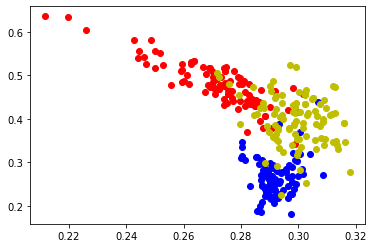

In [46]:
data_blues = dataframe[dataframe['class']==3]
data_rock = dataframe[dataframe['class']==5]
data_disco = dataframe[dataframe['class']==0]

variable1 = 'chroma_cens'
variable2 = 'fourier_mean'

        
plt.scatter(data_blues[variable1],data_blues[variable2],c='b')
plt.scatter(data_rock[variable1],data_rock[variable2],c='r')
plt.scatter(data_disco[variable1],data_disco[variable2],c='y')
plt.show()

In [14]:
dataframe[dataframe['class']=='country']

C:\Users\Sofus\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,zerocrossing,spectralrolloff,chromagramstd,chromagrammean,fourier_std,fourier_mean,chroma_cens,class,hardness,depth,brightness,roughness,warmth,sharpness,boominess,reverb


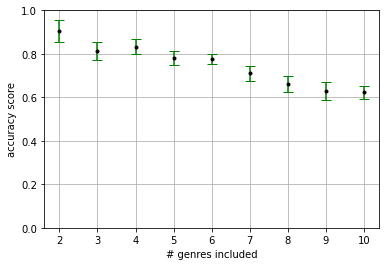

In [57]:
#################Test more genres, score


import random
    
scores_more_genres = np.array(np.zeros([9,10]))
scores_std_array = []
scores_mean_array = []

for jj in range(len(folders)-1):
    dataframe_cut = pd.DataFrame({})
    chosen_genres = [k for k in range(0,jj+2)]
    #print(chosen_genres)
    
    for i in chosen_genres:
        dataframe_cut = dataframe_cut.append(dataframe[dataframe['class']==i])

    dataframe_cut['class_num'] = pd.factorize(dataframe_cut['class'])[0]
    df_1=[]
    train_features = ['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std',
                      'fourier_mean','chroma_cens','hardness','depth','brightness','roughness','warmth',
                      'sharpness','boominess','reverb']
    
    df_1=dataframe_cut[train_features]

    Y_1=dataframe_cut['class_num']

    #Scaling using the Standard Scaler
    sc_1=StandardScaler()
    sc_1.fit(df_1)
    X_1=pd.DataFrame(sc_1.fit_transform(df_1))



    params={}
    params['boosting_type']='gbdt' #GradientBoostingDecisionTree
    params['objective']='multiclass' #Multi-class target feature
    params['metric']='multi_logloss' #metric for multi-class
    params['max_depth']=10
    params['num_class']=10
    params['num_leaves']=14
    params['force_col_wise']=True
    params['verbose'] = -1
    params['learning_rate']=0.2
    epochs = 100
    #len(os.listdir()) #no.of unique values in the target class not inclusive of the end value
    #training the model
    score_array=[]

    evals_result={}
    test = True

    if test==True:
        kk=0
        for param in range(10):
            #params['max_depth']=param+1
            X_train,X_test,y_train,y_test=train_test_split(X_1,Y_1,test_size=0.2,random_state=param+40)
            
            d_train=lgb.Dataset(X_train, label=y_train)

            clf=lgb.train(params,d_train, 50)

            y_pred_1=clf.predict(X_test)

            y_pred_m = [np.argmax(line) for line in y_pred_1]

            score = precision_score(y_pred_m,y_test,average=None).mean()
            score_array.append(score)
            scores_more_genres[jj][kk] = score
            kk=kk+1
    else:
        X_train,X_test,y_train,y_test=train_test_split(X_1,Y_1,test_size=0.2,random_state=30)
        d_train=lgb.Dataset(X_train, label=y_train)

        clf=lgb.train(params,d_train ,epochs)

        y_pred_1=clf.predict(X_test)

        y_pred_m = [np.argmax(line) for line in y_pred_1]

        score = precision_score(y_pred_m,y_test,average=None).mean()
        
    scores_std_array.append(np.std(scores_more_genres[jj][:]))
    scores_mean_array.append(np.mean(scores_more_genres[jj][:]))
 
f = plt.errorbar([2,3,4,5,6,7,8,9,10],scores_mean_array,scores_std_array,  fmt='.k', ecolor='g', capsize=5)
plt.xlabel('# genres included')
plt.ylabel('accuracy score')
plt.ylim([0,1])
plt.grid()
plt.savefig("no_genres_accuracy.pdf")

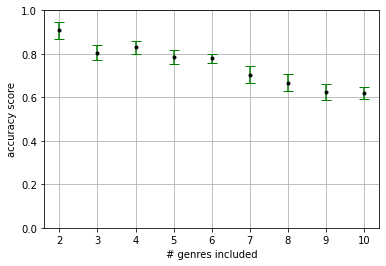

In [80]:
f = plt.errorbar([2,3,4,5,6,7,8,9,10],scores_mean_array,scores_std_array,  fmt='.k', ecolor='g', capsize=5)
plt.xlabel('# genres included')
plt.ylabel('accuracy score')
plt.ylim([0,1])
plt.grid()
plt.savefig("no_genres_accuracy.pdf")

In [13]:
###############################Make 2D plot of pred/test


dataframe_cut['class_num'] = pd.factorize(dataframe_cut['class'])[0]

df_1=[]
train_features = ['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std',
                  'fourier_mean','chroma_cens','hardness','depth','brightness','roughness','warmth',
                  'sharpness','boominess','reverb']

df_1=dataframe_cut[train_features]

Y_1=dataframe_cut['class_num']

#Scaling using the Standard Scaler
sc_1=StandardScaler()
sc_1.fit(df_1)
X_1=pd.DataFrame(sc_1.fit_transform(df_1))

y_pred_array = []
y_test_array = []

params={}
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=10
params['num_class']=10
params['num_leaves']=14
params['force_col_wise']=True
params['verbose'] = -1
params['learning_rate']=0.1
epochs = 500
#len(os.listdir()) #no.of unique values in the target class not inclusive of the end value
#training the model
score_array=[]

evals_result={}
test = True

if test==True:
    for param in range(100):
        print(param)
        #params['max_depth']=param+1
        X_train,X_test,y_train,y_test=train_test_split(X_1,Y_1,test_size=0.1,random_state=param+20)
        d_train=lgb.Dataset(X_train, label=y_train)

        clf=lgb.train(params,d_train,100)

        y_pred_1=clf.predict(X_test)

        y_pred_m = [np.argmax(line) for line in y_pred_1]
        
        y_pred_array = np.append(y_pred_array,y_pred_m)
        y_test_array = np.append(y_test_array,y_test)
        
pred_test_array = np.zeros([10,10])

for i in range(len(y_test_array)):
    pred_test_array[int(y_test_array[i])][int(y_pred_array[i])] +=1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


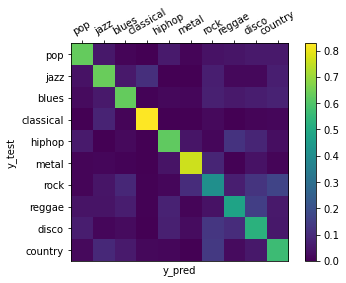

In [27]:
plt.figure()

plt.tight_layout()
plt.imshow(pred_test_array/(len(y_test_array)/10), interpolation='none')
plt.colorbar()
plt.figsize=(1000, 600)


plt.yticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=folders)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=folders)

plt.xticks(rotation=30)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.savefig("correlations_lrate01.pdf")
plt.show()



Normalized confusion matrix


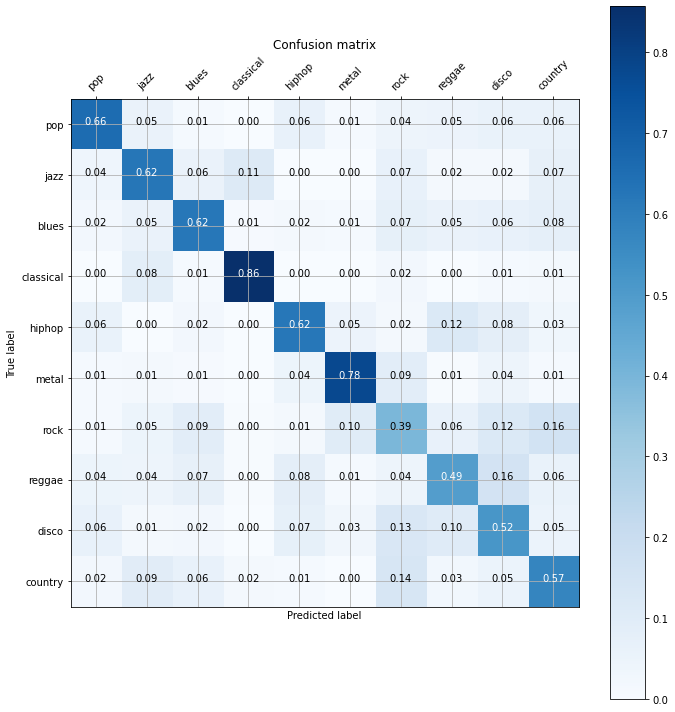

In [19]:
import itertools
from collections import OrderedDict


#keys = OrderedDict(sorted(folders.items(), key=lambda t: t[1])).keys()
plt.figure(figsize=(10,10))
plot_confusion_matrix(pred_test_array, folders, normalize=True)
plt.grid(None)
plt.tight_layout()

plt.tick_params(bottom=False, top=True, left=True, right=False)
plt.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)
plt.savefig('ConfusionMatrix.pdf')

In [60]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


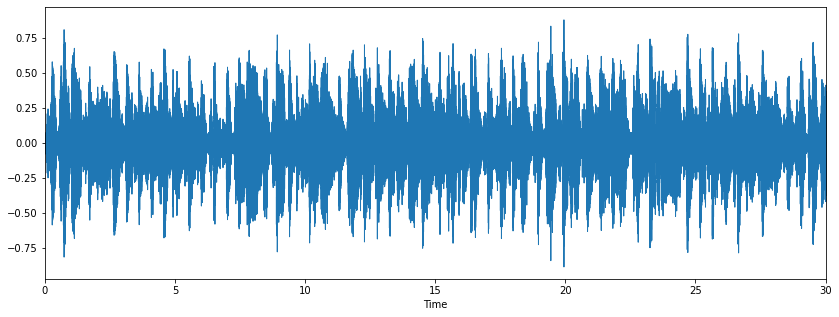

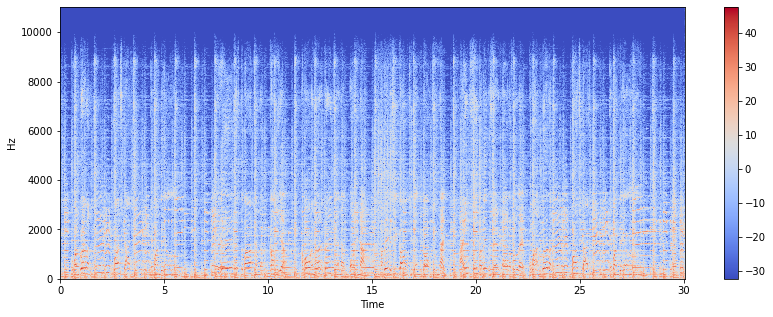

In [38]:
path = r'C:\Users\Sofus\Dropbox\PhD\ML\BigProjectGithub\music\wav\blues\blues.00000.wav'
x , sr = librosa.load(path)


plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()